Random Forest Model Evaluation:
Mean Squared Error: 493942.6407582726
R^2 Score: 0.9968993673872382


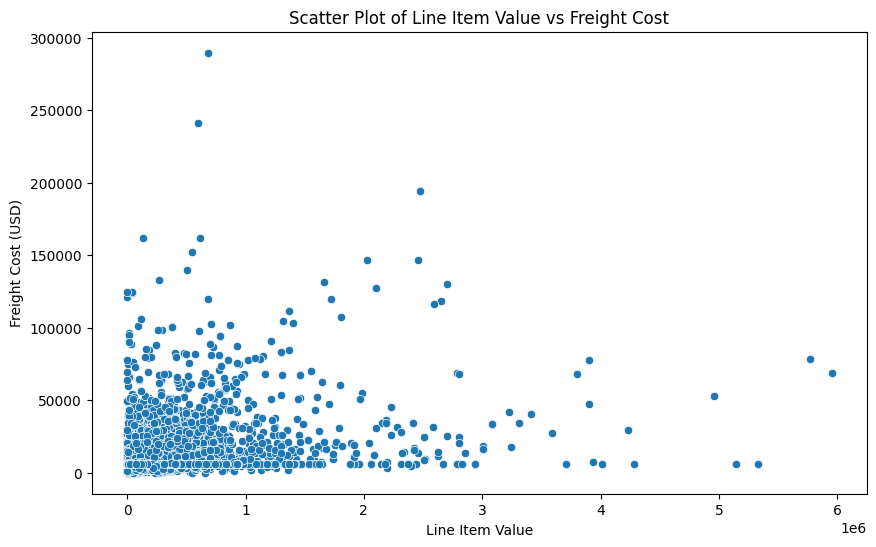

In [37]:
%run supply_chain_analysis.py

In [38]:
import pandas as pd
import numpy as np

# Then load the data
data = pd.read_csv('SCMS_Delivery_History_Dataset_20150929.csv', encoding='ISO-8859-1')

# Convert 'Freight Cost (USD)' to numeric, forcing non-numeric values to NaN
data['Freight Cost (USD)'] = pd.to_numeric(data['Freight Cost (USD)'], errors='coerce')

# You can choose to either fill NaN values or drop them
data['Freight Cost (USD)'] = data['Freight Cost (USD)'].fillna(data['Freight Cost (USD)'].median())

# OR
# data = data.dropna(subset=['Freight Cost (USD)'])

# Now calculate the quartiles and IQR for 'Freight Cost (USD)'
Q1 = data['Freight Cost (USD)'].quantile(0.25)
Q3 = data['Freight Cost (USD)'].quantile(0.75)
IQR = Q3 - Q1

# Define the outlier threshold
outlier_threshold = 1.5 * IQR
lower_bound = Q1 - outlier_threshold
upper_bound = Q3 + outlier_threshold

# Filter out the outliers
outliers = data[(data['Freight Cost (USD)'] < lower_bound) | (data['Freight Cost (USD)'] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])



Number of outliers detected: 1752


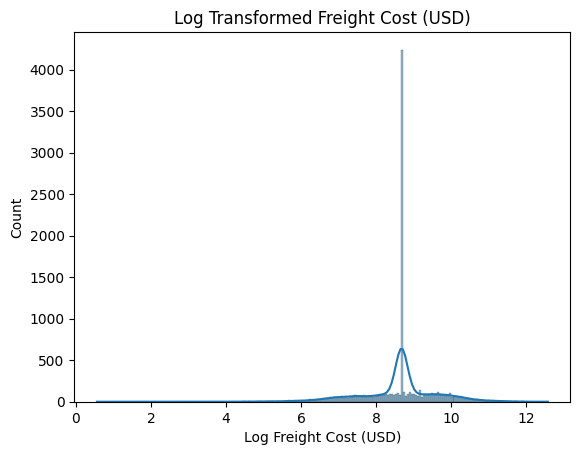

In [39]:
import numpy as np

# Log transform 'Freight Cost (USD)' to reduce skewness
data['Log Freight Cost (USD)'] = np.log1p(data['Freight Cost (USD)'])

# Visualize the transformation effect
sns.histplot(data['Log Freight Cost (USD)'], kde=True)
plt.title('Log Transformed Freight Cost (USD)')
plt.show()

In [40]:
# Ensure 'Weight (Kilograms)' is a numeric column. Attempt to convert it to numeric, forcing errors to NaN.
data['Weight (Kilograms)'] = pd.to_numeric(data['Weight (Kilograms)'], errors='coerce')

# Now you can calculate the 'Cost Per Kilogram' safely after handling NaNs
data['Weight (Kilograms)'] = data['Weight (Kilograms)'].fillna(0) # Handling NaNs if necessary, or you can choose to drop them
data['Cost Per Kilogram'] = data['Freight Cost (USD)'] / data['Weight (Kilograms)']

In [41]:
import scipy.stats as stats

# Perform ANOVA (Analysis of Variance) to compare means across different shipment modes
anova_result = stats.f_oneway(
    data[data['Shipment Mode'] == 'Air']['Freight Cost (USD)'],
    data[data['Shipment Mode'] == 'Truck']['Freight Cost (USD)'],
    data[data['Shipment Mode'] == 'Ocean']['Freight Cost (USD)']
)

print(f"ANOVA result: F={anova_result.statistic}, p={anova_result.pvalue}")

ANOVA result: F=19.456787111348937, p=3.695159758987794e-09


In [42]:
pivot_table_result = data.pivot_table(
    values='Freight Cost (USD)', 
    index='Shipment Mode', 
    columns='Vendor', 
    aggfunc='mean'
)

print(pivot_table_result)

Vendor         ABBOTT LABORATORIES (PUERTO RICO)  ABBOTT LOGISTICS B.V.  \
Shipment Mode                                                             
Air                                        314.0               5869.655   
Air Charter                                  NaN                    NaN   
Ocean                                        NaN                    NaN   
Truck                                        NaN                    NaN   

Vendor         ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)  \
Shipment Mode                                                    
Air                                                 6053.78386   
Air Charter                                                NaN   
Ocean                                              23501.36400   
Truck                                                      NaN   

Vendor         ABBVIE, SRL (FORMALLY ABBOTT LABORATORIES INTERNATIONAL CO.)  \
Shipment Mode                                                            

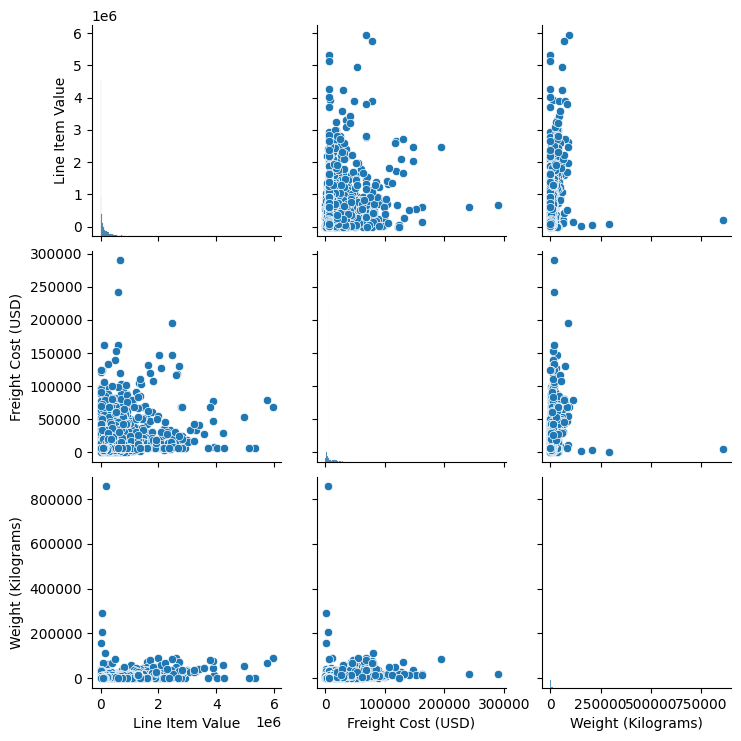

In [43]:
subset_data = data[['Line Item Value', 'Freight Cost (USD)', 'Weight (Kilograms)']]

# Pair plot using Seaborn
sns.pairplot(subset_data)
plt.show()

In [44]:
from sklearn.preprocessing import OneHotEncoder

# Encoding categorical variables (example for 'Shipment Mode')
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(data[['Shipment Mode']]).toarray()  # Use toarray() to convert to dense format


# Feature scaling (example for numerical features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['Line Item Value', 'Freight Cost (USD)']])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_features, data['Freight Cost (USD)'], test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)



Training data shape: (8259, 2)
Testing data shape: (2065, 2)
